In [2]:
import urllib3
import urllib.request
import numpy as np
from bs4 import BeautifulSoup #https://stackoverflow.com/questions/11023530/python-to-list-http-files-and-directories
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt

column_names = {'local_relative_humidity': 30, 'local_relative_humidity_uncertainty': 32}    
base_url = 'https://atmos.nmsu.edu/PDS/data/mslrem_1001/DATA/'
sol_epoch_starts = np.array([1, 90, 180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])
# num_epochs = sol_epoch_starts.size - 1
num_epochs = 1

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def get_epoch_name(index):
    string1 = str(sol_epoch_starts[index]) 
    string2 = str(sol_epoch_starts[index+1] - 1)
    string1 = '0' * (5 - len(string1)) + string1    
    string2 = '0' * (5 - len(string2)) + string2
    entire_string = 'SOL_' + string1 + '_' + string2
    return entire_string  

def get_sol_name(sol_num):
    string = str(sol_num)
    string = 'SOL' + '0' * (5 - len(string)) + string
    return string


http = urllib3.PoolManager()
data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
#     print(epoch_file_name)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
#         print("LOOK HERE:", 'base', base_url, 'epoch file', epoch_file_name, 'sol', sol_file_name)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break
# print(*data[:10], sep = '\n')
df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

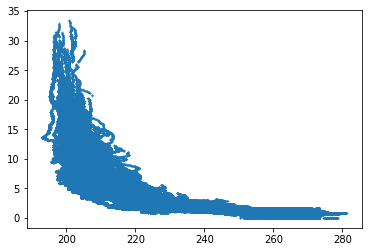

In [8]:
plt.plot(df[11], df[30], linestyle='', marker = 'o', markersize=0.7)

In [9]:
name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)

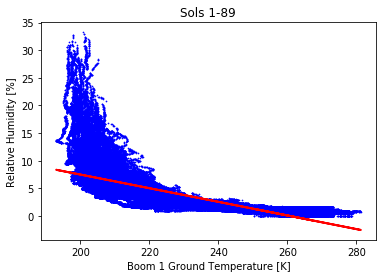

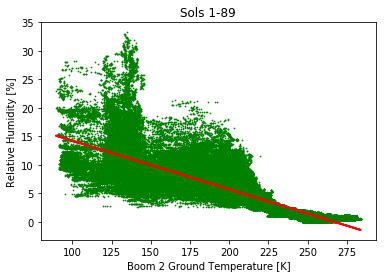

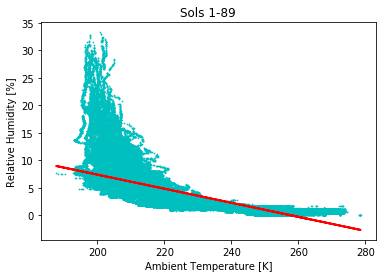

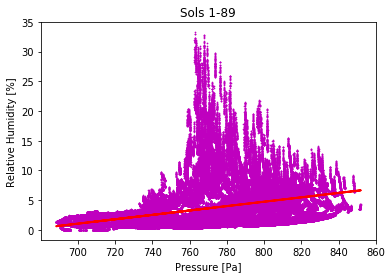

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
linreg = LinearRegression()

ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1) 
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
linreg.fit(ground_temp_1_train, rel_hum_train)
hum_pred = linreg.predict(ground_temp_1_test)
r2_temp1 = linreg.score(ground_temp_1_test, rel_hum_test)
f1_temp = plt.figure()
plt.plot(ground_temp_1_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'b')
plt.plot(ground_temp_1_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1-89')
plt.xlabel('Boom 1 Ground Temperature [K]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f1_temp.savefig("boom1_local_air_temp", bbox_inches='tight', dpi=600)

ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
linreg.fit(ground_temp_2_train, rel_hum_train)
hum_pred = linreg.predict(ground_temp_2_test)
r2_temp2 = linreg.score(ground_temp_2_test, rel_hum_test)
f2_temp = plt.figure()
plt.plot(ground_temp_2_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'g')
plt.plot(ground_temp_2_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1-89')
plt.xlabel('Boom 2 Ground Temperature [K]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f2_temp.savefig("boom2_local_air_temp", bbox_inches='tight', dpi=600)

amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1) 
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
linreg.fit(amb_temp_train, rel_hum_train)
hum_pred = linreg.predict(amb_temp_test)
r2_amb_temp = linreg.score(amb_temp_test, rel_hum_test)
f3_amb_temp = plt.figure()
plt.plot(amb_temp_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'c')
plt.plot(amb_temp_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1-89')
plt.xlabel('Ambient Temperature [K]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f3_amb_temp.savefig("amb_temp", bbox_inches='tight', dpi=600)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
linreg.fit(press_train, rel_hum_train)
hum_pred = linreg.predict(press_test)
r2_press = linreg.score(press_test, rel_hum_test)
f4_press = plt.figure()
plt.plot(press_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'm')
plt.plot(press_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1-89')
plt.xlabel('Pressure [Pa]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f4_press.savefig("pressure", bbox_inches='tight', dpi=600)

In [15]:
print(r2_temp1, r2_temp2, r2_amb_temp, r2_press)

0.5999833545605441 0.7502944890982628 0.591591863221111 0.14639675114179163


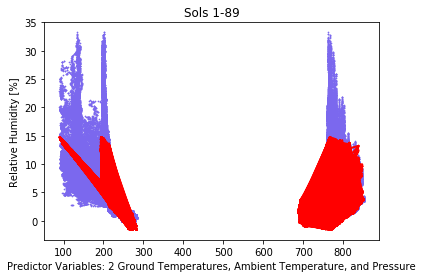

In [30]:
plt.rcParams['agg.path.chunksize'] = 20000
all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
linreg.fit(all_train, rel_hum_train)
hum_pred = linreg.predict(all_test)
r2_all = linreg.score(all_test, rel_hum_test)
f5_all = plt.figure()
plt.plot(all_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'mediumslateblue')
plt.plot(all_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1-89')
plt.xlabel('Predictor Variables: 2 Ground Temperatures, Ambient Temperature, and Pressure')
plt.ylabel('Relative Humidity [%]')
plt.show()
f5_all.savefig("all_x", bbox_inches='tight', dpi=600)


In [31]:
r2_all

0.7617721092805291